## Importowanie bibliotek
Biblioteka `morfeusz2` posłuży do lematyzacji, `plwordnet` i Słowosieć do analizy sentymentu. 

>**Słowosieć** (ang. PlWordNet) – baza danych leksykalno-semantycznych języka polskiego typu wordnet. Zawiera zestawy synonimicznych jednostek leksykalnych (synsety) opisanych krótkimi definicjami. Słowosieć służy jako słownik, w którym pojęcia (synsety) i poszczególne znaczenia wyrazów (jednostki leksykalne) zdefiniowane są poprzez miejsce w sieci wzajemnych relacji, odzwierciedlających system leksykalny polszczyzny. Słowosieć jest także wykorzystywana jako jeden z podstawowych zasobów do budowy programów przetwarzających język polski. ([Wikipedia](https://pl.wikipedia.org/wiki/S%C5%82owosie%C4%87))


- http://morfeusz.sgjp.pl/download/
- https://slowosiec.pl/

In [27]:
# import plwordnet
import morfeusz2
import pandas as pd
import numpy as np

In [28]:
# biblioteki do wizualizacji danych
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib_inline.backend_inline import set_matplotlib_formats
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image

set_matplotlib_formats('svg')

## Opis danych
Dane pochodzą z Reddita i Wykopu, zostały one zescrapowane przy uwzględnieniu następujących tagów: 

[Nasza dokumentacja procesu webscrapingu](https://github.com/dpiotrkowski/PSI-analiza-sentymentu/blob/main/src/README.md)

![](img/loga.png)

## Wstępne przetwarzanie tekstu
W tym punkcie podejmiemy następujące kroki:
1. Usunięcie niepotrzebnych znaków z tekstu źródłowego
2. Lematyzacja za pomocą Morfeusza
3. Usunięcie stop słów z lematów
   
Na początku załadujmy polski słownik sentymentu (ręcznie przefiltrowany `plwordnet` w csv). 

In [29]:
slownik_sentymentu = pd.read_csv('słowniki/SłownikSentymentu.csv', sep=';',encoding='cp1250')
# print(slownik_sentymentu.columns.tolist())

Wczytujemy zescrapowane pliki tekstowe z Reddita/Wykopu i dzielimy na pojedyncze słowa. Na samym końcu tworzymy ramkę danych, gdzie każde słowo jest w osobnym wierszu.

In [41]:
with open('data/results_reddit.txt', 'r', encoding='utf-8') as file:
    reddit_messy = file.read()
with open('data/results_wykop.txt', 'r', encoding='utf-8') as file:
    wykop_messy = file.read()
#slowa_r = tekst_caly_r.split()
#ramka_slow_r = pd.DataFrame(slowa_r, columns=['słowa'])

Kolejnym krokiem będzie przeczyszczenie wczytanego tekstu, czyli:
- usunięcie znaków interpunkcyjnych
- usunięcie niepożądanych słów z tekstu źródłowego
- usunięcie wszystkich linków z wpisów
- usunięcie liczb
- usunięcie polskich stop słów
  
W tym celu korzystamy z prostych list comprehensions.

In [43]:
niechciane_slowa_reddit = ['Tytuł','tytuł', 'Treść','treść','Tag', 'Subreddit']
niechciane_slowa_wykop = ['BRAK', 'TREŚCI', 'Tytuł','tytuł', 'Treść','treść','Tag', 'Subreddit']

def text_roomba(text, unwanted_words):
    # Znaki interpunkcyjne
    punctuation = '-,? .>#:"/[]+=!%<*()|–„'    
    table = str.maketrans('', '', punctuation)
    
    words = text.split()
    cleaned_words = [word.translate(table) for word in words]

    # Filter out unwanted words and empty strings
    filtered_words = [word for word in cleaned_words if word not in unwanted_words and word != '']

    # Remove links
    filtered_words_no_links = [
        word for word in filtered_words
        if not (word.startswith('http') or word.startswith('www'))
    ]
    
    # Remove digits
    filtered_words_final = [
        word for word in filtered_words_no_links
        if not word.isdigit()
    ]
    return filtered_words_final
# Example usage:
# unwanted_words = ['Tytuł', 'Treść', 'Tag', 'Subreddit']
# text = "Example Tytuł http://example.com 123 Hello!"
# cleaned_words = clean_text_for_sentiment_analysis(text, unwanted_words)
# print(cleaned_words)

reddit_txt = text_roomba(reddit_messy, niechciane_slowa_reddit)
wykop_txt = text_roomba(wykop_messy, niechciane_slowa_wykop)

Na koniec tworzymy ramkę danych z przefiltrowanymi słowami.

In [44]:
df_reddit = pd.DataFrame(reddit_txt, columns=['slowa'])
df_wykop = pd.DataFrame(wykop_txt, columns=['slowa'])

### Lematyzacja
O Morfeuszu twórcy piszą, że w skrócie to słownik morfologiczny.
Matura z polskiego już za nami za równo w wersji podstawowej, jak i rozszerzonej, a z Morfeusza korzystamy w wersji ze słownikiem gramatyki języka polskiego - [SGJP](http://sgjp.pl/o-slowniku/#liczby). 

**Ważne pojęcia** – czytamy dokumentację twórców
>Celem hasłowania (lematyzacji) jest wskazanie dla każdego słowa tekstowego opisującej je jednostki słownika morfologicznego (leksemu). Jest to więc analiza morfologiczna (lub tagowanie) ograniczona tylko do części informacji o formach — do lematów.

> Przybliżone hasłowanie polegające na odcięciu ze słów części zmieniającej się przy odmianie bywa nazywane stemowaniem. Metoda ta ma sens dla języków o ograniczonej fleksji, ale dla polskiego daje wyniki wysoce niezadowalające. W kontekście Morfeusza mówimy więc o prawdziwym hasłowaniu.

([Analizator morfologiczny Morfeusz](http://morfeusz.sgjp.pl/doc/about/)) 

In [45]:
morfeusz = morfeusz2.Morfeusz()

def lemmatize_word(word):
    analyses = morfeusz.analyse(word)
    if analyses:
        # analyses to lista krotek: (start, end, (lemma, tag), score)
        # Bierzemy pierwszą lematę z analizy
        lemma = analyses[0][2][1]  # [0] - pierwszy wynik, [2] - tuple (base, lemma, tag), [1] - lemma
        return lemma
    else:
        return word

df_reddit['lemma'] = df_reddit['slowa'].apply(lemmatize_word)
df_wykop['lemma'] = df_wykop['slowa'].apply(lemmatize_word)

Najczęstsze słowa

In [46]:
df_reddit['lemma_clean'] = df_reddit['lemma'].apply(lambda x: x.split(':')[0])
lemma_counts_reddit = df_reddit['lemma_clean'].value_counts()

df_wykop['lemma_clean'] = df_wykop['lemma'].apply(lambda x: x.split(':')[0])
lemma_counts_wykop = df_wykop['lemma_clean'].value_counts()

W końcu możemy przeczyścić lematy ze zbędnych słów - stopwords (się, na, i, w, itp...). W pliku `stopwords-pl.txt` znajdują się wszystkie stopsłowa. Pochodzi on z https://github.com/stopwords-iso/stopwords-pl

In [47]:
with open('słowniki/stopwords-pl.txt', 'r', encoding='utf-8') as file:
    df_polish_stop_words = file.read().splitlines()

df_reddit = df_reddit[~df_reddit['lemma_clean'].isin(df_polish_stop_words)]
word_freq_reddit = df_reddit['lemma_clean'].value_counts().head(125)

df_wykop = df_wykop[~df_wykop['lemma_clean'].isin(df_polish_stop_words)]
word_freq_wykop = df_wykop['lemma_clean'].value_counts().head(125)

lemma_clean
prezydent    182
wybory        86
kandydat      79
oda           60
państwo       58
            ... 
życie         12
tur           12
odwiedzić     12
oznaczać      12
prosty        12
Name: count, Length: 125, dtype: int64

lemma_clean
wybory        104
debata         34
Maciak         19
͡°             17
Maciej         13
             ... 
lud             2
kastralnym      2
wolny           2
warszawa        2
heheszki        2
Name: count, Length: 125, dtype: int64

### Chmura słów
Wykorzystamy teraz biblioteki do wizualizacji danych `matplotlib` i `worldcloud` do stworzenia chmury słów. W ramce danych `czestosci_slow` nadal występują słowa, które mogłyby zostać usunięte np. *prezydent*, *kandydat*, *wybory*. 

In [48]:
words_to_remove = ['polski', 'Polska', 'kandydat', 'prezydent','tenże','wybory', 'oda']
filtered_word_freq_reddit = {word: freq for word, freq in word_freq_reddit.items() if word not in words_to_remove}
filtered_word_freq_wykop = {word: freq for word, freq in word_freq_wykop.items() if word not in words_to_remove}

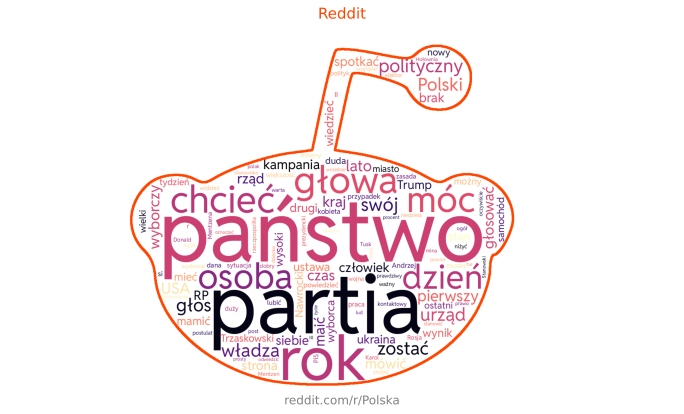

In [62]:
font_path = 'img/RedditSans.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
mask_path = 'img/mask-reddit.png'  
mask = Image.open(mask_path)
mask = mask.convert("L")  # Convert to grayscale
mask = np.array(mask)

wc = WordCloud(font_path = font_path,
               mask=mask,
               width=1920, height=1080,
               background_color = "white",
               colormap = "magma",
               contour_width=12,
               contour_color='#ff4500')
wc.generate_from_frequencies(filtered_word_freq_reddit)

plt.figure(figsize=(12,10),dpi=300)
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title('Reddit', color='#ff4500', fontsize=15)
plt.text(0.5, 0.0, 'reddit.com/r/Polska', ha='center', va='center', fontsize=12, color='gray', transform=plt.gca().transAxes)
plt.show()

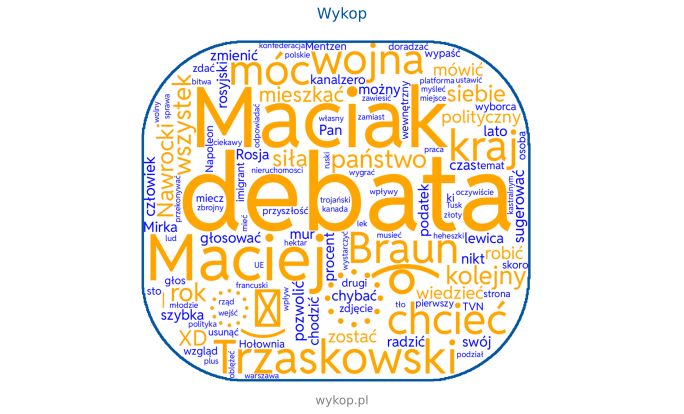

In [60]:
font_path = 'img/RedditSans.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
mask_path = 'img/wykop-mask.png'  
mask = Image.open(mask_path)
mask = mask.convert("L")  # Convert to grayscale
mask = np.array(mask)


def orange_center_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Get the frequency of the word
    frequency = wc.words_.get(word, 0)
    
    # Assign orange to the most frequent words and blue to others
    if frequency > 0.1:  # Adjust this threshold based on your needs
        return "orange"
    else:
        return "blue"


wc = WordCloud(font_path = font_path,
               mask=mask,
               width=1920, height=1080,
               background_color = "white",
               color_func=orange_center_color_func,
               #colormap = "magma",
               contour_width=12,
               contour_color='#0054a2')
wc.generate_from_frequencies(filtered_word_freq_wykop)

plt.figure(figsize=(12,10),dpi=300)
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title('Wykop', color='#0054a2', fontsize=15)
plt.text(0.5, 0.0, 'wykop.pl', ha='center', va='center', fontsize=12, color='gray', transform=plt.gca().transAxes)
plt.show()

## Analiza sentymentu
Przechodzimy do właściwej analizy sentymentu.

In [38]:
# Dołączenie słownika sentymentu
df_reddit = df_reddit.merge(
    slownik_sentymentu,
    left_on='lemma_clean', 
    right_on='lemat',
    how='left'
)

# Zliczenie ilości słów o danym ładunku emocjonalnym
sentyment_suma_reddit = df_reddit.groupby('nachechowanie').size().reset_index(name='ilosc')

# Pominięcie słów bez przypisanego ładunku
sentyment_suma_reddit = sentyment_suma_reddit[sentyment_suma_reddit['nachechowanie'].notna()]

Dołączamy słownik ładunków emocjonalnych do ostatecznie uzyskanej ramki danych i zliczamy wszystkie słowa o danym ładunku.

In [39]:

# Ustalenie kolejności argumentów
custom_order = ['+ m', '+ s', 'amb', '- s', '- m']
sentyment_suma_reddit['nachechowanie'] = pd.Categorical(
    sentyment_suma_reddit['nachechowanie'],
    categories=custom_order,
    ordered=True
)
sentyment_suma_reddit = sentyment_suma_reddit.sort_values('nachechowanie', ascending=False)

# Mapa kolorów dla skali emocji
color_map = {
    '+ m': '#2ecc40',   # Zielony
    '+ s': '#a3e048',   # Jasnozielony
    'amb': '#ffd700',   # Żółty
    '- s': '#ff8c00',   # Pomarańczowy
    '- m': '#e74c3c'    # Czerwony
}
sentyment_suma_reddit['color'] = sentyment_suma_reddit['nachechowanie'].map(color_map)

# Mapa opisowych nazw dla skali emocji
label_map = {
    '+ m': 'bardzo pozytywny',
    '+ s': 'pozytywny',
    'amb': 'niejednoznaczny',
    '- s': 'negatywny',
    '- m': 'bardzo negatywny'
}

 Rezultat zostaje przedstawiony na wykresie lizakowym za pomocą biblioteki `matplotlib`.

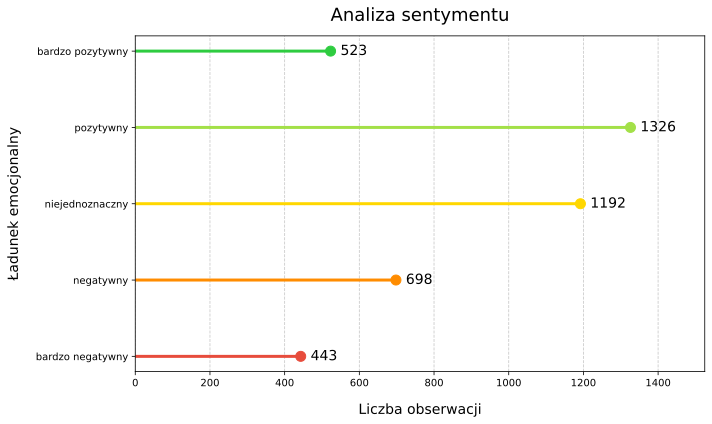

In [40]:
# Nowa kolumna z opisowymi nazwami do wyświetlenia na osi Y
sentyment_suma_reddit['label'] = sentyment_suma_reddit['nachechowanie'].map(label_map)
plt.figure(figsize=(10, 6))

# Wykres
for idx, row in sentyment_suma_reddit.iterrows():
    plt.hlines(
        y=row['label'],
        xmin=0,
        xmax=row['ilosc'],
        color=row['color'],
        linewidth=3
    )
    plt.plot(
        row['ilosc'],
        row['label'],
        'o',
        markersize=10,
        color=row['color']
    )
    plt.text(
        row['ilosc'] + max(sentyment_suma_reddit['ilosc']) * 0.02,
        row['label'],
        str(row['ilosc']),
        va='center',
        ha='left',
        fontsize=14,
        color='black'
    )

plt.title('Analiza sentymentu', fontsize=18, pad=15)
plt.xlabel('Liczba obserwacji', labelpad=15, fontsize = 14)
plt.ylabel('Ładunek emocjonalny', labelpad=15, fontsize = 14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
max_ilosc = sentyment_suma_reddit['ilosc'].max()
plt.xlim(0, max_ilosc * 1.15)
plt.tight_layout()
plt.show()